### Alter the following parameters to provide different graphs below

In [14]:
tests_dir = "../tests/"
# test_dir = tests_dir + "test_1_8_11_2021/" # change this to the folder you want displayed
# test_dir = tests_dir + "test_21_12_2021/"
# test_dir = tests_dir + "test_18_1_2022/"
test_dir = tests_dir + "test_17_3_2022/"


In [15]:
import json

def get_meta(test_dir):
    with open(test_dir + 'meta.json', 'r') as f:
        return json.load(f)

meta = get_meta(test_dir)

start_time = meta["start_time"]
end_time = meta["end_time"] #TODO: using a time greater than 10 breaks comparison
using_mesh = meta["using_mesh"]
frequency = meta["frequency"]

In [16]:
from os import listdir
from os.path import isfile, join

# get all servant drifter files
def get_file_name_list(test_dir):
    return [test_dir + f for f in listdir(test_dir) if isfile(join(test_dir, f)) and 'svt' in f]

file_name_list = get_file_name_list(test_dir)
print(file_name_list)

# get names of drifters from file names
def get_drifter_names(file_name_list):
    idxOfName = file_name_list[0].index('D')
    return [n[idxOfName : idxOfName + 3] for n in file_name_list]

drifter_names = get_drifter_names(file_name_list)

['../tests/test_17_3_2022/svtD01.csv', '../tests/test_17_3_2022/svtD02.csv', '../tests/test_17_3_2022/svtD04.csv', '../tests/test_17_3_2022/svtD05.csv', '../tests/test_17_3_2022/svtD06.csv', '../tests/test_17_3_2022/svtD07.csv', '../tests/test_17_3_2022/svtD08.csv', '../tests/test_17_3_2022/svtD10.csv']


### Importing Data

In [17]:
import os, csv
import matplotlib.pyplot as plt
import pandas as pd

In [18]:
def read_from_CSV(file_name, frequency, start_time, end_time):
  data = []
  with open(file_name, 'r', newline='') as csvfile:
      csv_reader = csv.reader(csvfile, quoting=csv.QUOTE_ALL)
      for idx, row in enumerate(csv_reader):
          if len(row) == 0:
              continue
          else:
              if '#FILE ERASED AT' not in row:
                  if idx != 0:
                      if idx % frequency == 0:
                          if row[1] > start_time and row[1] < end_time:
                              if len(row) == 20:
                                  row.pop()
                              data.append(row)
      csvfile.close()
      return data

In [19]:
def make_drifter_list(file_name_list, frequency, start_time, end_time, using_mesh=False):
  drifter_list = [None] * len(file_name_list)
  for idx, file_name in enumerate(file_name_list):
    data = read_from_CSV(file_name, frequency, start_time, end_time)
    if not using_mesh:
      drifter_list[idx] = pd.DataFrame(data, columns=['Date', 'Time', 'Longitude', 'Latitude', 'GPS Age'])
    # else:
      # drifter_list[idx] = pd.DataFrame(data, columns=['Date', 'Time', 'Longitude', 'Latitude', 'GPS Age', 'Sent',
      # 'Received', 'Master','D01', 'D02','D03','D04','D05','D06','D07'])
    else:
      drifter_list[idx] = pd.DataFrame(data, columns=['Date', 'Time', 'Longitude', 'Latitude', 'GPS Age', 'Battery',
      'Sent', 'Received', 'Master', 'D01', 'D02','D03','D04','D05','D06','D07', 'D08', 'D09', 'D10'])
  for df in drifter_list:
    print(df.head())
  return drifter_list

drifter_list = make_drifter_list(file_name_list, frequency, start_time, end_time, using_mesh)

        Date    Time   Longitude    Latitude GPS Age Battery Sent Received  \
0  2022-3-17   4:4:5  115.707524  -32.149164     138   98.00   48        0   
1  2022-3-17  4:4:35  115.708077  -32.151231      25   97.93   54        0   
2  2022-3-17   4:5:5  115.708261  -32.153331     181   97.93   54        0   
3  2022-3-17  4:5:35  115.708380  -32.155441     127   97.98   60        0   
4  2022-3-17   4:6:5  115.708726  -32.157531     270   97.98   60        0   

  Master D01 D02 D03 D04 D05 D06 D07 D08 D09 D10  
0      0   0   0   0   0   0   0   0   0   0   0  
1      0   0   0   0   0   0   0   0   0   0   0  
2      0   0   0   0   0   0   0   0   0   0   0  
3      0   0   0   0   0   0   0   0   0   0   0  
4      0   0   0   0   0   0   0   0   0   0   0  
        Date    Time   Longitude    Latitude GPS Age Battery Sent Received  \
0  2022-3-17  4:5:22  115.708262  -32.154313      50   97.64   24        0   
1  2022-3-17  4:5:52  115.708551  -32.156457      71   97.66   24    

### Calculating local velocities

In [20]:
import math
from datetime import datetime

# Same as TinyGPS library calculation
def get_distance(lat1, lon1, lat2, lon2):
    delta = math.radians(lon1 - lon2)
    sdlong = math.sin(delta)
    cdlong = math.cos(delta)
    lat1 = math.radians(lat1)
    lat2 = math.radians(lat2)
    slat1 = math.sin(lat1)
    clat1 = math.cos(lat1)
    slat2 = math.sin(lat2)
    clat2 = math.cos(lat2)
    delta = (clat1 * slat2) - (slat1 * clat2 * cdlong)
    delta = delta ** 2
    delta += (clat2 * sdlong) ** 2
    delta = math.sqrt(delta)
    denom = (slat1 * slat2) + (clat1 * clat2 * cdlong)
    delta = math.atan2(delta, denom)
    return delta * 6372795

In [21]:
def split_time_from_df(drifter, using_mesh=False):
  drifter_stamps = []
  for ii in range(len(drifter) - 1):
    # print(drifter_stamps)
    date_stamp = drifter.Date[ii]
    if not using_mesh:
      new_date_stamp = date_stamp.split('/')
    else:
      new_date_stamp = date_stamp.split('-')
    timestamp = drifter.Time[ii]
    new_timestamp = timestamp.split(':')
    drifter_stamps.append([*new_date_stamp, *new_timestamp])
  return drifter_stamps

In [22]:
# def calc_overall_local_currents(drifter_list, drifter_names):
#   drifter_stamps = split_time_from_df(drifter_list[0], using_mesh)
#   start_time_stamps = list(map(int, drifter_stamps[0]))
#   end_time_stamps = list(map(int, drifter_stamps[-1]))
#   start_time = datetime(start_time_stamps[2], start_time_stamps[1], start_time_stamps[0], start_time_stamps[3], start_time_stamps[4], start_time_stamps[5])
#   end_time = datetime(end_time_stamps[2], end_time_stamps[1], end_time_stamps[0], end_time_stamps[3], end_time_stamps[4], end_time_stamps[5])
#   time_delta_s = (end_time - start_time).total_seconds()
#   print('Total drift time')
#   print(time_delta_s, 's\n')
#   for idx, drifter in enumerate(drifter_list):
#     lat_1 = float(drifter.Latitude[0])
#     lon_1 = float(drifter.Longitude[0])
#     lat_2 = float(drifter.Latitude[len(drifter) - 1])
#     lon_2 = float(drifter.Longitude[len(drifter) - 1])
  
#     print(drifter_names[idx])
#     dist = get_distance(lat_1, lon_1, lat_2, lon_2)
#     print("Total distance: ", dist, 'm')
#     velocity = dist/time_delta_s
#     print("Velocity: ", velocity, 'm/s')

# calc_overall_local_currents(drifter_list, drifter_names)

In [23]:
def get_time_delta_start_to_end(drifter_stamps):
    stamp = drifter_stamps[0]
    stamp = list(map(int, stamp))
    stamp_2 = drifter_stamps[len(drifter_stamps) - 1]
    stamp_2 = list(map(int, stamp_2))
    if not using_mesh:
        start_time = datetime(stamp[2], stamp[1], stamp[0], stamp[3], stamp[4], stamp[5])
        end_time = datetime(stamp_2[2], stamp_2[1], stamp_2[0], stamp_2[3], stamp_2[4], stamp_2[5])
    else:
        start_time = datetime(stamp[0], stamp[1], stamp[2], stamp[3], stamp[4], stamp[5])
        end_time = datetime(stamp_2[0], stamp_2[1], stamp_2[2], stamp_2[3], stamp_2[4], stamp_2[5])
    return (end_time - start_time).total_seconds()

def get_time_delta(drifter_stamps, ii):
    stamp = drifter_stamps[ii]
    stamp = list(map(int, stamp))
    stamp_2 = drifter_stamps[ii + 1]
    stamp_2 = list(map(int, stamp_2))
    if not using_mesh:
        start_time = datetime(stamp[2], stamp[1], stamp[0], stamp[3], stamp[4], stamp[5])
        end_time = datetime(stamp_2[2], stamp_2[1], stamp_2[0], stamp_2[3], stamp_2[4], stamp_2[5])
    else:
        start_time = datetime(stamp[0], stamp[1], stamp[2], stamp[3], stamp[4], stamp[5])
        end_time = datetime(stamp_2[0], stamp_2[1], stamp_2[2], stamp_2[3], stamp_2[4], stamp_2[5])
    return (end_time - start_time).total_seconds()

In [24]:
def calc_individual_local_currents(drifter_list, drifter_names, using_mesh=False):
    for drifter in drifter_list:
        velocity_list = []
        drifter_stamps = split_time_from_df(drifter, using_mesh)
        for ii in range(len(drifter_stamps) - 1):
            time_delta_s = get_time_delta(drifter_stamps, ii)
            lat_1 = float(drifter.Latitude[ii])
            lon_1 = float(drifter.Longitude[ii])
            lat_2 = float(drifter.Latitude[ii + 1])
            lon_2 = float(drifter.Longitude[ii + 1])
            dist = get_distance(lat_1, lon_1, lat_2, lon_2)
            # print('Distance:', dist, 'm')
            velocity = dist / time_delta_s
            velocity_list.append(velocity)
        yield velocity_list

currents_velocities = calc_individual_local_currents(drifter_list, drifter_names, using_mesh)

ValueError: month must be in 1..12

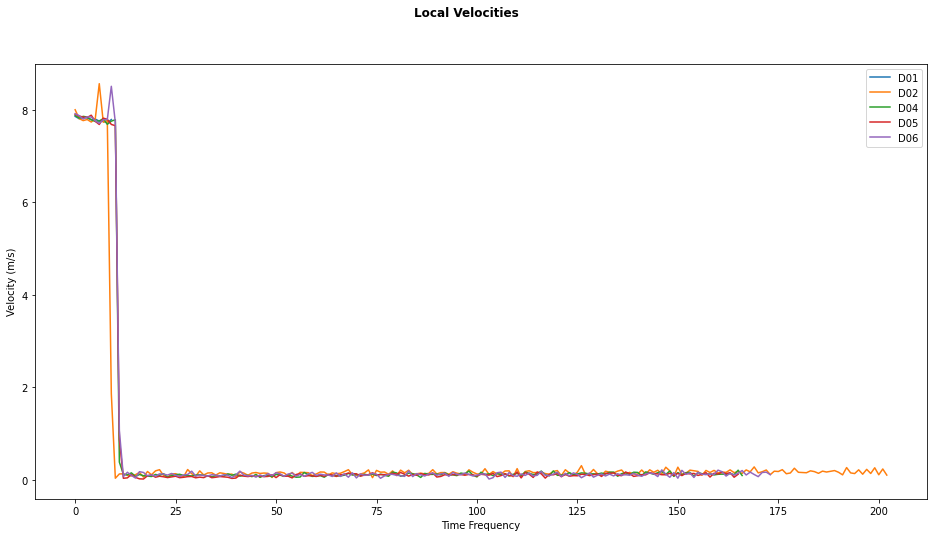

In [25]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

def plot_local_velocities(currents_velocities, drifter_names):
    fig = plt.figure(figsize=(16,8))
    
    fig.suptitle("""Local Velocities\n\n""", fontweight ="bold") 
    for idx, curr in enumerate(currents_velocities):
        plt.plot(curr, label=drifter_names[idx])
        plt.ylabel('Velocity (m/s)')
        plt.xlabel('Time Frequency')
        plt.legend()
    fig.show()

plot_local_velocities(currents_velocities, drifter_names)

In [ ]:
def get_times_from_start(drifter):
    drifter_stamps = split_time_from_df(drifter, using_mesh)
    return get_time_delta_start_to_end(drifter_stamps)

def get_battery_consumption(drifter_list, time_since_start_s):
    for drifter in drifter_list:
        batt_start = (float)(drifter.Battery[0])
        batt_last = (float)(drifter.Battery[len(drifter.Battery) - 1])
        yield (batt_start - batt_last) / time_since_start_s

# consumption starts at %/sec
def output_battery_consumption(consumption):
    print(f"{consumption:.4f}% per second")
    print(f"{consumption * 60:.4f}% per minute")
    print(f"{consumption * 60 * 60:.4f}% per hour")

time_since_start_s = get_times_from_start(drifter_list[0])
battery_consumptions = get_battery_consumption(drifter_list, time_since_start_s)

for consumption in battery_consumptions:
    output_battery_consumption(consumption)

0.0003% per second
0.0157% per minute
0.9401% per hour
0.0011% per second
0.0664% per minute
3.9816% per hour
0.0011% per second
0.0636% per minute
3.8157% per hour
0.0009% per second
0.0544% per minute
3.2627% per hour
0.0033% per second
0.1968% per minute
11.8065% per hour
0.0013% per second
0.0760% per minute
4.5622% per hour
0.0012% per second
0.0733% per minute
4.3963% per hour
0.0009% per second
0.0521% per minute
3.1244% per hour


### Plotting GPS locations

In [26]:
import folium

swan_coordinates = [-31.9976045, 115.8226236] # good coordinates for swan river test 1
farm_coordinates = [-33.9316144, 115.1822156] # remove these later
glendalough_coords = [-31.919785, 115.8111968] # remove these later
cockburn_sound_coords = [-32.097313, 115.709433] # remove these later

coords = cockburn_sound_coords

swan_map = folium.Map(location=coords, zoom_start=13)

# using frequency defined at top of notebook
# Many points causes map to lag a great deal
def add_markers_to_map(map, drifter_list, drifter_names, with_radius=False):
    colour_list = ['blue', 'orange', 'gray', 'green', 'lightblue', 'lightgray', 'lightred', 'darkred', 'darkgreen',
        'purple', 'lightgreen', 'red', 'pink', 'beige', 'black', 'darkpurple', 'darkblue', 'white', 'cadetblue']
    for idx, drifter in enumerate(drifter_list):
        for ii in range(len(drifter.Longitude)):
            folium.Marker(
                location=[drifter.Latitude[ii], drifter.Longitude[ii]],
                popup=f"<stong>Pos: {ii} </stong>",
                icon=folium.Icon(icon="none", color=colour_list[idx]),
                tooltip=drifter_names[idx]).add_to(map)
            if with_radius:
                folium.Circle([drifter.Latitude[ii], drifter.Longitude[ii]],
                    color=colour_list[idx],
                    radius=2000).add_to(map)
        map.add_child(folium.LatLngPopup())
    return map

swan_map_w_markers = add_markers_to_map(swan_map, drifter_list, drifter_names, False)
swan_map_w_markers